# Imports

In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, concatenate
from keras.layers import GlobalMaxPooling1D, Conv1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import gensim
from gensim.models import Word2Vec
from navec import Navec
from sklearn.metrics import classification_report
from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB

from sklearn.utils import class_weight

from matplotlib import pyplot as plt

import io

import seaborn as sns

Using TensorFlow backend.


# EDA

Исходная база - 4730 уникальных кусочков, посвященных инфляции. Данные уже изначально были лемматизированы и почищены

О задаче: предсказание проинфляционности новости,  
+ 2 - проинфляционные
+ 1 - дезинфляционные
+ 0 - нейтральные

In [252]:
pd.set_option('max_colwidth', 400)

In [253]:
df = pd.read_excel('3cat.xlsx')
df = df.drop_duplicates()
df.columns = ['news', 'class']

количество объектов и фич

In [254]:
df.shape

(4730, 2)

классы немного несбалансированы

<AxesSubplot:xlabel='class', ylabel='count'>

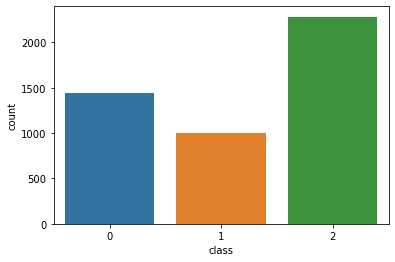

In [255]:
import seaborn as sns

sns.countplot(x='class', data=df)

проверка на пропуски

In [256]:
df.isnull().sum()

news     0
class    0
dtype: int64

In [257]:
df.head()

,news,class
0,республика это рассказывать сайт гтрк чувашия цена поезд новый год житель чувашия смочь покупать,0
1,открываться долг приходиться оплачивать текущий тариф ипосколька платный парковка центр город большой,0
2,тема становиться изменение уровень потребительский цена тариф жкх подчеркивать глава республика михаил,0
3,составлять объем потребление коммунальный услуга тариф соответствующий услуга объяснять сайт тариф,0
4,республика должный составлять около учет инфляция доход значительно низко средний государство,0


Убираю все символы, кроме киррилицы и пробелов.

In [258]:
df['news'] = df['news'].str.replace('?', '', regex=False)
df['news'] = df['news'].str.replace('[a-zA-Z]', '')

In [259]:
X = data_test['news'].to_list()
y = data_test['class'].to_list()
fdist = nltk.FreqDist()
X_proc = []
for sent in X:
    sent = sent.split()
    for word in sent:
        fdist[word.lower()] += 1
    sent = ' '.join(sent)
    X_proc.append(sent)

X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=42)

График частотности слов. Словарь специфичен (основа - экономические термины), так как состоит только лишь из кусочков новостей, посвященных инфляции

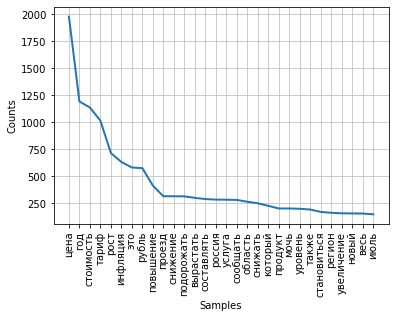

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [260]:
fdist.plot(30,cumulative=False)

tf-idf для кусочков

In [261]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(X_train)
X_train_tfidf = Tfidf_vect.transform(X_train)
X_test_tfidf = Tfidf_vect.transform(X_test)

получаем разреженную матрицу, словарь - 5769 слов. Здесь ограничения на min и max частоту, либо абсолют не накладывались

In [262]:
X_train_tfidf.shape

(3784, 5769)

Кросс-валидация по 5 фолдам с перемешиванием

In [263]:
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=42)

# Estimation

## Naive Bayes

Baseline - Naive Bayes. Хоть и наивный (слова пораждаются независимо по наивному предположению), но неплохо работает. Multinomial Naive Bayes как раз подходит для целей NLP

In [271]:
Naive = MultinomialNB()

Сделаем поиск по сетке по гиперпараметку $\alpha$

In [272]:
from sklearn.model_selection import GridSearchCV
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
grid_search= GridSearchCV(Naive, parameters, cv=cv, scoring='f1_weighted')
grid_search.fit(X_train_tfidf,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
             estimator=MultinomialNB(),
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)},
             scoring='f1_weighted')

In [273]:
grid_search.best_estimator_

MultinomialNB(alpha=0.1)

In [284]:
y_pred_naive = grid_search.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_naive))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       283
           1       0.81      0.52      0.63       212
           2       0.70      0.88      0.78       451

    accuracy                           0.70       946
   macro avg       0.72      0.65      0.67       946
weighted avg       0.71      0.70      0.69       946



F-weighted = 0.7, что будет являться базовым качеством.

## SVM

SVM - мейнстрим для решения задач классификации текстов.

In [282]:
clf = SVC(class_weight='balanced', probability=True, kernel='linear') # здесь балансируем классы в самой модели

Опять же поиск по сетке. Для целей NLP конечно необходимо именно линейное ядро

In [283]:
grid = {'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
        'C': [1, 10, 100, 1000, 10000]},
svm_model = GridSearchCV(estimator=clf, param_grid=grid, cv=cv, scoring='f1_weighted', n_jobs=-1)
svm_model.fit(X_train_tfidf, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
             estimator=SVC(class_weight='balanced', kernel='linear',
                           probability=True),
             n_jobs=-1,
             param_grid=({'C': [1, 10, 100, 1000, 10000],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05]},),
             scoring='f1_weighted')

In [285]:
y_pred_svm = svm_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       283
           1       0.91      0.88      0.89       212
           2       0.95      0.93      0.94       451

    accuracy                           0.91       946
   macro avg       0.90      0.90      0.90       946
weighted avg       0.91      0.91      0.91       946



F-weighted = 0.91, что уже является сильным приростом, по сравнению с Naive Bayes

## Xgboost

Из ансамблевых моделей также стоит попробовать градиентный бустинг, который может тоже показать хороший результат на данных.

In [294]:
from sklearn.model_selection import KFold
from scipy import stats
import xgboost

#здесь уже перехожу к RandomizedSearchCV для более эффективного поиска на сетке
model = xgboost.XGBClassifier(nthread=4, objective='binary:logistic', random_state=1)
param_dist = {'n_estimators': stats.randint(20, 500),
              "colsample_bytree": [0.6, 0.8, 1.0],
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.8),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4],
              "gamma": [0, 0.1, 0.3,0.4],
             }
numFolds = 5
clf = RandomizedSearchCV(model, 
                         param_distributions = param_dist,
                         cv = cv,  
                         n_iter = 5,
                         scoring = 'f1_weighted', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:42:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
                   error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth...
                                        'gamma': [0, 0.1, 0.3, 0.4],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DFA89A68E0>,
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
             

In [295]:
y_pred_xg = svm_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       283
           1       0.91      0.88      0.89       212
           2       0.95      0.93      0.94       451

    accuracy                           0.91       946
   macro avg       0.90      0.90      0.90       946
weighted avg       0.91      0.91      0.91       946



Результат оказался сопоставим с SVM. Однако в пользу бустинга говорит то, что он является более быстрым методом, чем SVM.